<a href="https://colab.research.google.com/github/bharthiyuva/NMPROJECT/blob/main/YUVARAJ%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulated Data Head:
                   timestamp  road_segment_id weather_condition  \
0 2024-12-29 12:26:01.272194               32             Clear   
1 2024-08-20 20:26:01.272229               36             Rainy   
2 2025-03-20 07:26:01.272235               37             Clear   
3 2025-04-23 14:26:01.272241               48             Foggy   
4 2024-10-07 18:26:01.272247               14             Rainy   

   traffic_volume  speed_limit  average_speed road_condition  \
0             428           70      23.846480           Fair   
1             646           90      37.405554           Good   
2             438           70      58.624862           Good   
3            3281           70      37.682191           Good   
4            3141           50      34.747594           Poor   

  lighting_condition  num_accidents_past_week accident_severity  \
0           Daylight                        2              None   
1           Daylight                        9            

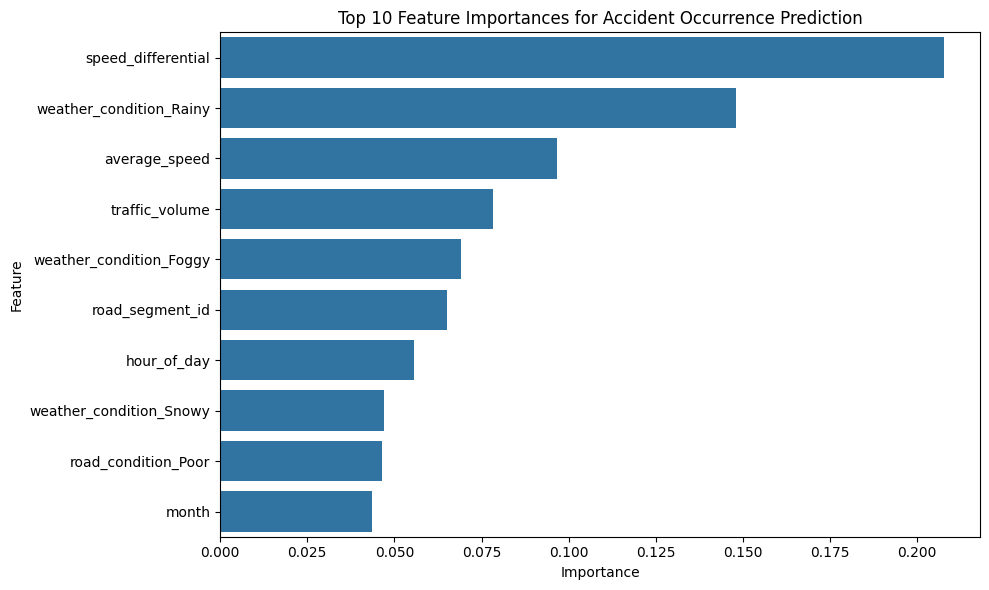


--- Training Accident Severity Classifier ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# --- 1. Simulated Data Generation ---
# In a real scenario, you would load your data from a CSV, database, or API.
def generate_simulated_traffic_data(num_samples=1000):
    np.random.seed(42) # for reproducibility

    data = {
        'timestamp': [datetime.datetime.now() - datetime.timedelta(days=int(np.random.rand()*365)) - datetime.timedelta(hours=int(np.random.rand()*24)) for _ in range(num_samples)],
        'road_segment_id': np.random.randint(1, 50, num_samples),
        'weather_condition': np.random.choice(['Clear', 'Rainy', 'Foggy', 'Snowy'], num_samples, p=[0.6, 0.25, 0.1, 0.05]),
        'traffic_volume': np.random.randint(100, 5000, num_samples),
        'speed_limit': np.random.choice([30, 50, 70, 90], num_samples, p=[0.2, 0.4, 0.3, 0.1]),
        'average_speed': np.random.uniform(20, 80, num_samples),
        'road_condition': np.random.choice(['Good', 'Fair', 'Poor'], num_samples, p=[0.7, 0.2, 0.1]),
        'lighting_condition': np.random.choice(['Daylight', 'Dark_unlit', 'Dark_lit'], num_samples, p=[0.7, 0.15, 0.15]),
        'num_accidents_past_week': np.random.randint(0, 10, num_samples), # Historical data
        'accident_severity': np.random.choice(['None', 'Minor', 'Moderate', 'Fatal'], num_samples, p=[0.75, 0.15, 0.07, 0.03]), # Target for classification
        'accident_occurred': np.random.randint(0, 2, num_samples) # Target for binary classification (0: no accident, 1: accident)
    }

    df = pd.DataFrame(data)

    # Introduce some correlation: e.g., bad weather/poor road increases accidents
    for i in range(num_samples):
        if df.loc[i, 'weather_condition'] in ['Rainy', 'Foggy', 'Snowy'] or \
           df.loc[i, 'road_condition'] == 'Poor' or \
           df.loc[i, 'average_speed'] > df.loc[i, 'speed_limit'] * 1.1: # Speeding
            if np.random.rand() < 0.6: # Higher chance of accident
                df.loc[i, 'accident_occurred'] = 1
                df.loc[i, 'accident_severity'] = np.random.choice(['Minor', 'Moderate', 'Fatal'], p=[0.5, 0.3, 0.2])
            else:
                df.loc[i, 'accident_severity'] = 'None'
        else:
            if np.random.rand() < 0.05: # Small chance of accident even in good conditions
                 df.loc[i, 'accident_occurred'] = 1
                 df.loc[i, 'accident_severity'] = np.random.choice(['Minor', 'Moderate'], p=[0.7, 0.3])
            else:
                df.loc[i, 'accident_occurred'] = 0
                df.loc[i, 'accident_severity'] = 'None'

    # Ensure 'None' severity corresponds to 'accident_occurred' = 0
    df.loc[df['accident_occurred'] == 0, 'accident_severity'] = 'None'
    # Ensure 'accident_occurred' = 1 when severity is not 'None'
    df.loc[df['accident_severity'] != 'None', 'accident_occurred'] = 1


    return df

df = generate_simulated_traffic_data(num_samples=5000)
print("Simulated Data Head:")
print(df.head())
print("\nSimulated Data Info:")
print(df.info())
print("\nAccident Severity Distribution:")
print(df['accident_severity'].value_counts())
print("\nAccident Occurred Distribution:")
print(df['accident_occurred'].value_counts())


# --- 2. Feature Engineering ---
# Creating new features that might be more predictive.
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek # Monday=0, Sunday=6
df['month'] = df['timestamp'].dt.month
df['speed_differential'] = df['average_speed'] - df['speed_limit']

# Encode categorical features
categorical_features = ['weather_condition', 'road_condition', 'lighting_condition']
for col in categorical_features:
    df = pd.get_dummies(df, columns=[col], prefix=col, drop_first=True)

# For the target variable 'accident_severity', we need to encode it ordinally
# Or, for classification, we can predict binary 'accident_occurred'
# For 'accident_severity' as a multi-class target:
severity_mapping = {'None': 0, 'Minor': 1, 'Moderate': 2, 'Fatal': 3}
df['accident_severity_encoded'] = df['accident_severity'].map(severity_mapping)

print("\nData after Feature Engineering and Encoding:")
print(df.head())

# --- 3. AI Model for Accident Prediction (Binary Classification) ---
# Predicting if an accident will occur (Yes/No)

X_classification = df.drop(['timestamp', 'accident_severity', 'accident_severity_encoded', 'accident_occurred'], axis=1)
y_classification = df['accident_occurred']

# Handle potential non-numeric columns after get_dummies (shouldn't happen if all are encoded)
# Ensure all remaining features are numerical
for col in X_classification.columns:
    if X_classification[col].dtype == 'object':
        le = LabelEncoder()
        X_classification[col] = le.fit_transform(X_classification[col])

# Scale numerical features (important for many ML models, especially neural networks, not strictly necessary for RF but good practice)
scaler = StandardScaler()
numerical_cols = X_classification.select_dtypes(include=np.number).columns
X_classification[numerical_cols] = scaler.fit_transform(X_classification[numerical_cols])


X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42, stratify=y_classification)

print("\n--- Training Accident Occurrence Classifier ---")
model_occurrence = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # 'balanced' handles class imbalance
model_occurrence.fit(X_train_cls, y_train_cls)

y_pred_cls = model_occurrence.predict(X_test_cls)
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_cls):.4f}")
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_cls))

# Feature Importance
feature_importances = pd.Series(model_occurrence.feature_importances_, index=X_classification.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index)
plt.title('Top 10 Feature Importances for Accident Occurrence Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- 4. AI Model for Accident Severity Prediction (Multi-class Classification) ---
# This is only relevant for rows where an accident *did* occur.
# For simplicity, we'll train on the full dataset and let the model predict 'None' if no accident.
# Alternatively, filter for accident_occurred == 1 and then predict severity.

X_severity = df.drop(['timestamp', 'accident_severity', 'accident_occurred', 'accident_severity_encoded'], axis=1)
y_severity = df['accident_severity_encoded']

# Ensure all remaining features are numerical
for col in X_severity.columns:
    if X_severity[col].dtype == 'object':
        le = LabelEncoder()
        X_severity[col] = le.fit_transform(X_severity[col])

# Scale numerical features
X_severity[numerical_cols] = scaler.fit_transform(X_severity[numerical_cols]) # Re-scale as it's a new X

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(X_severity, y_severity, test_size=0.2, random_state=42, stratify=y_severity)

print("\n--- Training Accident Severity Classifier ---")
# 'balanced' class weight is crucial here due to high imbalance in severity types
model_severity = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_severity.fit(X_train_sev, y_train_sev)

y_pred_sev = model_severity.predict(y_test_sev)
print(f"Accuracy: {accuracy_score(y_test_sev, y_pred_sev):.4f}")
print("Classification Report (Severity):")
print(classification_report(y_test_sev, y_pred_sev, target_names=severity_mapping.keys()))

# --- 5. AI Model for Accident Frequency Prediction (Regression) ---
# Predicting the number of accidents in a given time period/road segment.
# For simplicity, let's try to predict 'num_accidents_past_week' based on current features.
# In a real scenario, this would involve time-series data or aggregate features for segments.

X_regression = df.drop(['timestamp', 'accident_severity', 'accident_severity_encoded', 'accident_occurred', 'num_accidents_past_week'], axis=1)
y_regression = df['num_accidents_past_week']

# Ensure all remaining features are numerical
for col in X_regression.columns:
    if X_regression[col].dtype == 'object':
        le = LabelEncoder()
        X_regression[col] = le.fit_transform(X_regression[col])

# Scale numerical features
X_regression[numerical_cols] = scaler.fit_transform(X_regression[numerical_cols])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

print("\n--- Training Accident Frequency Regressor ---")
model_frequency = RandomForestRegressor(n_estimators=100, random_state=42)
model_frequency.fit(X_train_reg, y_train_reg)

y_pred_reg = model_frequency.predict(X_test_reg)
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_reg, y_pred_reg):.4f}")
print(f"R-squared (R2): {r2_score(y_test_reg, y_pred_reg):.4f}")

# --- 6. Example Prediction Usage ---
# Let's create a hypothetical new data point for prediction.
# In a real system, this would come from sensors, weather APIs, etc.

# Create a sample input similar to how X_classification was structured
sample_data = {
    'road_segment_id': 15,
    'traffic_volume': 3500,
    'speed_limit': 70,
    'average_speed': 85, # Speeding
    'num_accidents_past_week': 2,
    'hour_of_day': 18, # Rush hour
    'day_of_week': 2, # Wednesday
    'month': 11,
    'speed_differential': 15,
    'weather_condition_Rainy': 0, # Assuming no rain
    'weather_condition_Snowy': 0, # Assuming no snow
    'weather_condition_Foggy': 1, # Foggy conditions
    'road_condition_Poor': 1, # Poor road condition
    'road_condition_Good': 0,
    'lighting_condition_Dark_unlit': 1, # Dark and unlit
    'lighting_condition_Dark_lit': 0
}

# Convert to DataFrame
sample_df = pd.DataFrame([sample_data])

# Reorder columns to match training data (crucial for consistent predictions)
sample_df = sample_df[X_classification.columns]

# Apply scaling using the same scaler used during training
sample_df[numerical_cols] = scaler.transform(sample_df[numerical_cols])

print("\n--- Making Predictions for a New Scenario ---")

# Predict accident occurrence
occurrence_prediction = model_occurrence.predict(sample_df)
occurrence_proba = model_occurrence.predict_proba(sample_df)[:, 1][0] # Probability of accident

print(f"Predicted Accident Occurrence: {'Yes' if occurrence_prediction[0] == 1 else 'No'}")
print(f"Probability of Accident: {occurrence_proba:.2f}")

if occurrence_prediction[0] == 1:
    # Predict severity if an accident is predicted
    severity_prediction_encoded = model_severity.predict(sample_df)
    predicted_severity = next(key for key, value in severity_mapping.items() if value == severity_prediction_encoded[0])
    print(f"Predicted Accident Severity: {predicted_severity}")
else:
    print("No severity prediction as no accident is predicted.")

# Predict accident frequency
frequency_prediction = model_frequency.predict(sample_df)
print(f"Predicted Number of Accidents (in a similar past week context): {frequency_prediction[0]:.2f}")

# --- 7. Conceptual AI-driven Road Safety Enhancements ---

print("\n--- Conceptual AI-driven Road Safety Enhancements ---")
print("Based on the predictions, AI can enable:")
print("1.  **Proactive Alerts:** Alert traffic management centers about high-risk road segments (e.g., if probability of accident > 0.5).")
print("2.  **Dynamic Traffic Management:**")
print("    - Adjust speed limits on digital signs in real-time during adverse conditions (fog, heavy rain).")
print("    - Optimize traffic signal timings to reduce congestion in predicted high-accident areas.")
print("3.  **Resource Allocation:**")
print("    - Deploy more patrol units to high-risk zones during peak hours or bad weather.")
print("    - Prioritize road maintenance in areas predicted to have poor conditions leading to accidents.")
print("4.  **Driver Information Systems:** Integrate predictions into navigation apps to warn drivers about dangerous segments or suggest alternative routes.")
print("5.  **Infrastructure Planning:** Use long-term accident frequency predictions to identify hotspots for infrastructure improvements (e.g., better lighting, road surface upgrades, roundabout installation).")
print("6.  **Policy Making:** Provide data-driven insights for urban planning and traffic safety policies.")

if occurrence_prediction[0] == 1:
    print(f"\nExample actionable insight for the predicted scenario (Foggy, Poor Road, Speeding, Dark, Unlit):")
    print(f"- Recommend immediate deployment of variable message signs warning drivers about 'Dense Fog Ahead' and 'Reduced Speed Limit'.")
    print(f"- Dispatch maintenance crew for urgent inspection/repair of road segment {sample_data['road_segment_id']}.")
    print(f"- Increase police presence to enforce speed limits.")
else:
    print(f"\nExample actionable insight for the predicted scenario (low accident probability):")
    print(f"- Continue monitoring traffic conditions.")